##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [228]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [229]:
orig_df = pd.read_csv('../../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [230]:
df = pd.read_csv('../../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [231]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [232]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [233]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [263]:
import pandas as pd

# Assuming you have already loaded your DataFrame 'df' as described in your original code

# Display the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(df.head())

# Identify input and target variables
input_features = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']]
target_variable = df['VictimCount']

# Check the range of values in each column
print("\nRange of values in each column:")
for column in df.columns:
    min_value = df[column].min()
    max_value = df[column].max()
    print(f"{column}: Min = {min_value}, Max = {max_value}")

# You can use the describe() method for more statistics on the DataFrame
print(df.describe())


First few rows of the DataFrame:
            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  

Range of values in each column:
X: Min = -116.0, Max = -114.6255705
Y: Min = 35.0684190000001, Max = 37.0000000000001
Area_Command: Min = 0, Max = 11
NIBRSOffenseCode: Min = 0, Max = 2
DayOfWeek: Min = 0, Max = 6
Time: Min = 0, Max = 23
VictimCount: Min = 0, Max = 6
                X           Y  Area_Command  NIBRSOffenseCode   DayOfWeek  \
count  275.000000  275.000000    275.000000        275.00

# Information about columns

* Each column has about 275 datapoints
* X and Y columns are latitude and longitude which location of the the crime happened
* Area_Command column is the police area where the incident has happened it ranges from 0 to 11
* NIBRSOffenseCode is the classification code for the crime committed it ranges from 0 to 2
* DayOfWeek column represents the days of the week from 0 to 6 i.e Sunday to Saturday
* Time column represents the time from 0 i.e 12:00 Am to 23 i.e 11:00 Pm
* Victim count column provides data about how many victims are involved in the crime, it ranges from 0 to 6

## I think there is no need to scale, shift or normalize the data as the data is well distributed in my view.

In [264]:
target_variable[:50]

0     0
1     0
2     1
3     2
4     0
5     1
6     2
7     1
8     0
9     0
10    0
11    1
12    1
13    0
14    1
15    1
16    1
17    1
18    0
19    1
20    0
21    1
22    0
23    0
24    0
25    1
26    0
27    1
28    0
29    1
30    0
31    0
32    0
33    1
34    1
35    1
36    1
37    1
38    1
39    0
40    0
41    0
42    1
43    1
44    0
45    0
46    0
47    0
48    1
49    0
Name: VictimCount, dtype: int64

### After looking at the target data points I have noticed that there is an imbalance in the data as one type of target points such as 0's and 1's are more and other datapoints are less, so I have used the oversampling technique to oversample the data and make the data balance.
### This oversampled data is used in both the models below and found that it helps in classification model better giving the good accuracy.

In [265]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler  # Import RandomOverSampler for oversampling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 

# Oversample the minority class
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(input_features, target_variable)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize and train your classifier (e.g., RandomForestClassifier)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Evaluate your model on the test data
accuracy = clf.score(X_test, y_test)
print(f"Model Accuracy: {accuracy}")


Model Accuracy: 0.8793969849246231


In [267]:
day_counts = y_resampled.value_counts()
print(day_counts)

VictimCount
0    142
1    142
2    142
3    142
4    142
5    142
6    142
Name: count, dtype: int64


## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [238]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert pandas DataFrames to PyTorch tensors
X = torch.Tensor(input_features.values)
y = torch.Tensor(target_variable.values)

# X = torch.Tensor(X_resampled.values)
# y = torch.Tensor(y_resampled.values)
# Define batch size (you can choose a reasonable value)
batch_size = 64

# Create a TensorDataset for your data
dataset = TensorDataset(X, y)

# Split your dataset into training and testing (e.g., 80% for training and 20% for testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the shape of the data by iterating over one dataset (e.g., training data)
for inputs, targets in train_loader:
    print("Batch Input Shape:", inputs.shape)
    print("Batch Target Shape:", targets.shape)
    break  # Exit the loop after the first batch

Batch Input Shape: torch.Size([64, 6])
Batch Target Shape: torch.Size([64])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

## About the model
1. The proper loss function for this task would be the Mean squared error loss function as it's suitable when you want to minimize the squared differences between predicted and actual values. I have tried other loss functions but found the MSE better performing
2. The size of the prefucted output will be 1 as the regression model predicts a real number i.e predicts a single continuous value.
3. My neural network architecture will be having 2 hidden layers will size 128 and 256 as I have tried different numbers but these numbers performed better
4. I have used the Stochastic Gradient Descent optimizer with the learning rate of 0.001
5. The model is training well as the mse is gradually decreasing and achieved 0.57 which I think is acceptable.

In [247]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import math

# Define the model
class CrimePredictionModel(nn.Module):
    def __init__(self, input_size, hidden_size,hidden_size1, hidden_size2, output_size):
        super(CrimePredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.Sigmoid()  # Use ReLU activation function
        self.fc2 = nn.Linear(hidden_size, hidden_size1)  # Additional hidden layer
        self.relu2 = nn.ReLU() 
        self.fc3 = nn.Linear(hidden_size1, hidden_size2)  # Additional hidden layer
        self.relu3 = nn.ReLU() # Use ReLU activation function
        self.fc4 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

# Create an instance of the model
input_size = 6  # Replace with the actual input size
hidden_size = 256
hidden_size1 = 128
hidden_size2 = 64
output_size = 1
model = CrimePredictionModel(input_size, hidden_size, hidden_size1, hidden_size2, output_size)

criterion = nn.MSELoss()
# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Assuming you have your DataLoader objects defined as train_loader and test_loader
# and you have created your model as model

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        # Reshape the target tensor
        targets = targets.view(-1, 1)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        train_loss+= loss
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)

    # Calculate MSE on the test data
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            # Reshape the target tensor
            targets = targets.view(-1, 1) 
            test_loss += criterion(outputs, targets)
    
    test_loss /= len(test_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {test_loss.item()}')





Epoch [1/50], Test Loss: 1.0511219501495361
Epoch [2/50], Test Loss: 0.9829515814781189
Epoch [3/50], Test Loss: 0.9140350222587585
Epoch [4/50], Test Loss: 0.8534408807754517
Epoch [5/50], Test Loss: 0.8009267449378967
Epoch [6/50], Test Loss: 0.755296528339386
Epoch [7/50], Test Loss: 0.7176141738891602
Epoch [8/50], Test Loss: 0.6879886984825134
Epoch [9/50], Test Loss: 0.666486382484436
Epoch [10/50], Test Loss: 0.6470557451248169
Epoch [11/50], Test Loss: 0.6309584975242615
Epoch [12/50], Test Loss: 0.6150751709938049
Epoch [13/50], Test Loss: 0.6059531569480896
Epoch [14/50], Test Loss: 0.5995270013809204
Epoch [15/50], Test Loss: 0.5918951034545898
Epoch [16/50], Test Loss: 0.5877686738967896
Epoch [17/50], Test Loss: 0.5830305218696594
Epoch [18/50], Test Loss: 0.5800525546073914
Epoch [19/50], Test Loss: 0.5775761604309082
Epoch [20/50], Test Loss: 0.574963390827179
Epoch [21/50], Test Loss: 0.5726308822631836
Epoch [22/50], Test Loss: 0.5720557570457458
Epoch [23/50], Test Lo

## If we use the oversampled data here below then with the Adam optimizer and with learning rate 0.01 with 500 epocs the loss is decreasing and converging to 0.57 which is good.

In [278]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import math

# Convert pandas DataFrames to PyTorch tensors
X = torch.Tensor(X_resampled.values)
y = torch.Tensor(y_resampled.values)

# X = torch.Tensor(X_resampled.values)
# y = torch.Tensor(y_resampled.values)
# Define batch size (you can choose a reasonable value)
batch_size = 64

# Create a TensorDataset for your data
dataset = TensorDataset(X, y)

# Split your dataset into training and testing (e.g., 80% for training and 20% for testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Define the model

class CrimePredictionModel(nn.Module):
    def __init__(self, input_size, hidden_size,hidden_size1, hidden_size2, output_size):
        super(CrimePredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.Sigmoid()  # Use ReLU activation function
        self.fc2 = nn.Linear(hidden_size, hidden_size1)  # Additional hidden layer
        self.relu2 = nn.ReLU() 
        self.fc3 = nn.Linear(hidden_size1, hidden_size2)  # Additional hidden layer
        self.relu3 = nn.ReLU() # Use ReLU activation function
        self.fc4 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

# Create an instance of the model
input_size = 6  # Replace with the actual input size
hidden_size = 256
hidden_size1 = 128
hidden_size2 = 64
output_size = 1
model = CrimePredictionModel(input_size, hidden_size, hidden_size1, hidden_size2, output_size)

criterion = nn.MSELoss()
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Assuming you have your DataLoader objects defined as train_loader and test_loader
# and you have created your model as model

num_epochs = 500

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        # Reshape the target tensor
        targets = targets.view(-1, 1)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        train_loss+= loss
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)

    # Calculate MSE on the test data
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            # Reshape the target tensor
            targets = targets.view(-1, 1) 
            test_loss += criterion(outputs, targets)
    
    test_loss /= len(test_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {test_loss.item()}')





Epoch [1/500], Test Loss: 3.479349374771118
Epoch [2/500], Test Loss: 3.4194488525390625
Epoch [3/500], Test Loss: 3.819431781768799
Epoch [4/500], Test Loss: 3.458411931991577
Epoch [5/500], Test Loss: 2.8712968826293945
Epoch [6/500], Test Loss: 3.5559935569763184
Epoch [7/500], Test Loss: 2.3875036239624023
Epoch [8/500], Test Loss: 2.073930025100708
Epoch [9/500], Test Loss: 2.250183582305908
Epoch [10/500], Test Loss: 1.758828043937683
Epoch [11/500], Test Loss: 1.631063461303711
Epoch [12/500], Test Loss: 1.7407317161560059
Epoch [13/500], Test Loss: 1.7271900177001953
Epoch [14/500], Test Loss: 1.875875473022461
Epoch [15/500], Test Loss: 1.3932278156280518
Epoch [16/500], Test Loss: 1.2737064361572266
Epoch [17/500], Test Loss: 1.3995790481567383
Epoch [18/500], Test Loss: 1.5907633304595947
Epoch [19/500], Test Loss: 1.4907605648040771
Epoch [20/500], Test Loss: 1.2245242595672607
Epoch [21/500], Test Loss: 1.2175074815750122
Epoch [22/500], Test Loss: 1.1414752006530762
Epoch

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

## About the classification model
1. By using the .value_counts() function and finding its length gives me the number of classes on the output data
2. The neural network architecture is a bit different as in the output layer we map it to the the number of classes i.e 7 as it is a classification model
3. The loss function I am using is the Cross Entropy loss function as there are multiple class prediction
4. The best accuracy I can get is 53 percent in the training and 43  percent in the testing 

In [240]:
len(target_variable.value_counts())

7

In [241]:
torch.max(outputs,1)

torch.return_types.max(
values=tensor([0.5311, 0.5340, 0.5283, 0.5315, 0.5239, 0.5281, 0.5336, 0.5314, 0.5283,
        0.5319, 0.5384, 0.5407, 0.5311, 0.5415, 0.5329, 0.5410, 0.5405, 0.5312,
        0.5258, 0.5318, 0.5479, 0.5265, 0.5294, 0.5455, 0.5289, 0.5338, 0.5371,
        0.5448, 0.5243, 0.5364, 0.5418, 0.5344, 0.5243, 0.5344, 0.5422, 0.5418,
        0.5350, 0.5308, 0.5344, 0.5438, 0.5212, 0.5414, 0.5409, 0.5397, 0.5435,
        0.5394, 0.5224, 0.5277, 0.5295, 0.5307, 0.5342, 0.5327, 0.5237, 0.5313,
        0.5397]),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]))

In [262]:
import torch
import torch.nn as nn
import torch.optim as optim

num_classes = 7  # Define the number of classes (e.g., Low, Medium, High)
input_size = 6
hidden_size = 128
hidden_size1 = 64
hidden_size2 = 32

# Define the model
class CrimeClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size1, hidden_size2, output_size):
        super(CrimeClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.Tanh()  # Use ReLU activation function
        self.fc2 = nn.Linear(hidden_size, hidden_size1)  # Additional hidden layer
        self.relu2 = nn.ReLU() 
        self.fc3 = nn.Linear(hidden_size1, hidden_size2)  # Additional hidden layer
        self.relu3 = nn.ReLU() # Use ReLU activation function
        self.fc4 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out


# Define the model, data loaders, loss function, and optimizer
model = CrimeClassificationModel(input_size, hidden_size, hidden_size1, hidden_size2, num_classes)  # Adjust input_size and num_classes
criterion = nn.CrossEntropyLoss()  # Cross-Entropy Loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming you have defined train_loader and test_loader

num_epochs = 50

for epoch in range(num_epochs):
    model.train()  # Set the model in training mode

    train_loss = 0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        targets = targets.long()
        loss = criterion(outputs, targets)  # Calculate the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    train_loss /= len(train_loader)
    train_accuracy = correct / total

    # Calculate accuracy on the test data
    model.eval()  # Set the model in evaluation mode
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            targets = targets.long()
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = correct / total

    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')



Epoch [1/50]
Training Loss: 1.8942, Training Accuracy: 27.73%
Test Loss: 1.6891, Test Accuracy: 43.64%
Epoch [2/50]
Training Loss: 1.5527, Training Accuracy: 53.64%
Test Loss: 1.4282, Test Accuracy: 43.64%
Epoch [3/50]
Training Loss: 1.2567, Training Accuracy: 53.64%
Test Loss: 1.2666, Test Accuracy: 43.64%
Epoch [4/50]
Training Loss: 1.1855, Training Accuracy: 53.64%
Test Loss: 1.2442, Test Accuracy: 43.64%
Epoch [5/50]
Training Loss: 1.1414, Training Accuracy: 53.64%
Test Loss: 1.2394, Test Accuracy: 43.64%
Epoch [6/50]
Training Loss: 1.1215, Training Accuracy: 53.64%
Test Loss: 1.2084, Test Accuracy: 43.64%
Epoch [7/50]
Training Loss: 1.1069, Training Accuracy: 53.64%
Test Loss: 1.1801, Test Accuracy: 43.64%
Epoch [8/50]
Training Loss: 1.1050, Training Accuracy: 53.64%
Test Loss: 1.1721, Test Accuracy: 43.64%
Epoch [9/50]
Training Loss: 1.1210, Training Accuracy: 53.64%
Test Loss: 1.1801, Test Accuracy: 43.64%
Epoch [10/50]
Training Loss: 1.1355, Training Accuracy: 53.64%
Test Loss:

### Using the ovesampled data for the classification model gives better accuracy for the model, I think oversampled data helps the classification model to predict better with 80% accuracy

In [283]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert pandas DataFrames to PyTorch tensors
X = torch.Tensor(X_resampled.values)
y = torch.Tensor(y_resampled.values)

# X = torch.Tensor(X_resampled.values)
# y = torch.Tensor(y_resampled.values)
# Define batch size (you can choose a reasonable value)
batch_size = 64

# Create a TensorDataset for your data
dataset = TensorDataset(X, y)

# Split your dataset into training and testing (e.g., 80% for training and 20% for testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_classes = 7  # Define the number of classes (e.g., Low, Medium, High)
input_size = 6
hidden_size = 128
hidden_size1 = 64
hidden_size2 = 32

# Define the model
class CrimeClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size1, hidden_size2, output_size):
        super(CrimeClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.Tanh()  # Use ReLU activation function
        self.fc2 = nn.Linear(hidden_size, hidden_size1)  # Additional hidden layer
        self.relu2 = nn.ReLU() 
        self.fc3 = nn.Linear(hidden_size1, hidden_size2)  # Additional hidden layer
        self.relu3 = nn.ReLU() # Use ReLU activation function
        self.fc4 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out


# Define the model, data loaders, loss function, and optimizer
model_oversam = CrimeClassificationModel(input_size, hidden_size, hidden_size1, hidden_size2, num_classes)  # Adjust input_size and num_classes
criterion = nn.CrossEntropyLoss()  # Cross-Entropy Loss for classification
optimizer = optim.Adam(model_oversam.parameters(), lr=0.001)

# Assuming you have defined train_loader and test_loader

num_epochs = 200

for epoch in range(num_epochs):
    model.train()  # Set the model in training mode

    train_loss = 0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model_oversam(inputs)  # Forward pass
        targets = targets.long()
        loss = criterion(outputs, targets)  # Calculate the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    train_loss /= len(train_loader)
    train_accuracy = correct / total

    # Calculate accuracy on the test data
    model.eval()  # Set the model in evaluation mode
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model_oversam(inputs)
            targets = targets.long()
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = correct / total

    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')



Epoch [1/200]
Training Loss: 1.9446, Training Accuracy: 13.58%
Test Loss: 1.9364, Test Accuracy: 14.07%
Epoch [2/200]
Training Loss: 1.9280, Training Accuracy: 22.89%
Test Loss: 1.9226, Test Accuracy: 27.64%
Epoch [3/200]
Training Loss: 1.9071, Training Accuracy: 24.40%
Test Loss: 1.8942, Test Accuracy: 29.65%
Epoch [4/200]
Training Loss: 1.8693, Training Accuracy: 31.82%
Test Loss: 1.8451, Test Accuracy: 26.13%
Epoch [5/200]
Training Loss: 1.8039, Training Accuracy: 30.19%
Test Loss: 1.7574, Test Accuracy: 26.13%
Epoch [6/200]
Training Loss: 1.7346, Training Accuracy: 30.19%
Test Loss: 1.6729, Test Accuracy: 27.64%
Epoch [7/200]
Training Loss: 1.6373, Training Accuracy: 36.73%
Test Loss: 1.5949, Test Accuracy: 45.73%
Epoch [8/200]
Training Loss: 1.5754, Training Accuracy: 39.87%
Test Loss: 1.5331, Test Accuracy: 46.73%
Epoch [9/200]
Training Loss: 1.4993, Training Accuracy: 39.87%
Test Loss: 1.4985, Test Accuracy: 49.25%
Epoch [10/200]
Training Loss: 1.4624, Training Accuracy: 46.67%


## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

### Experience about the models of regression and classification
* The regression model is behaving well as the loss is decresing and converging well, I think the regression model is better than the classification model
* The classification model accuracy is not crossing accuracy of 53% for the training and for the testing the accuracy is 43% and loss is not decreasing and maintainig same values even if we use other optimizer or increase the hidden layers.
* Therefore, the regression model would be good to use with this data as per my knowledge.
* However, by using the oversampled data the classification model accuracy increases which can help in predicting the output better as the regression model performs similar with or without the oversampled data

### Below is the miss-classification example for classification model without using oversampled data

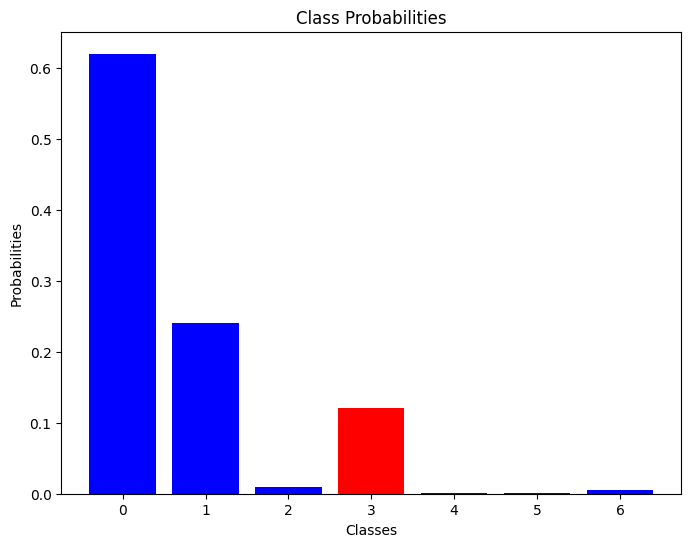

True Label: 3
Predicted Label: 0


In [243]:
import matplotlib.pyplot as plt
import torch

# Replace this with your actual input data
input_example = torch.tensor([[-115.2602,   36.2732,    8.0000,    1.0000,    5.0000,   20.0000]])

# Replace this with the true class label
true_label = 3

# Put the model in evaluation mode
model.eval()

# Forward pass to get class probabilities
with torch.no_grad():
    outputs = model(input_example)
    probabilities = torch.softmax(outputs, dim=1).numpy()[0]

# Find the predicted class (the one with the highest probability)
predicted_class = torch.argmax(outputs, dim=1).item()

# Check if it's a misclassification
if predicted_class != true_label:
    # Get class labels (you may have defined them elsewhere)
    class_labels = [0, 1, 2, 3, 4, 5, 6]

    # Plot the probabilities as a bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(class_labels, probabilities, color=['blue' if i != true_label else 'red' for i in range(len(class_labels))])
    plt.xlabel("Classes")
    plt.ylabel("Probabilities")
    plt.title("Class Probabilities")
    plt.show()

    print(f"True Label: {class_labels[true_label]}")
    print(f"Predicted Label: {class_labels[predicted_class]}")
else:
    print("No misclassification found.")


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


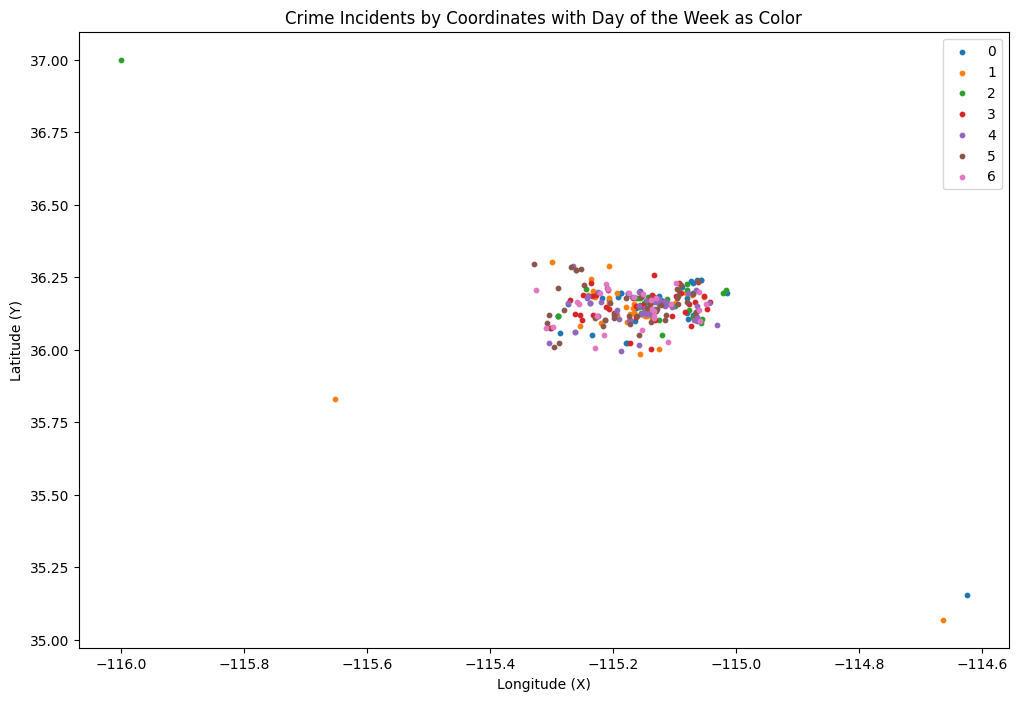

In [244]:
import matplotlib.pyplot as plt

# Create a scatter plot using coordinates and color by the day of the week
plt.figure(figsize=(12, 8))
days_of_week = df['DayOfWeek'].unique()

for day in days_of_week:
    day_data = df[df['DayOfWeek'] == day]
    plt.scatter(day_data['X'], day_data['Y'], label=day, s=10)

plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Incidents by Coordinates with Day of the Week as Color')
plt.legend()
plt.show()


### The crime incidents are mostly occuring on some co-ordinates as seen above

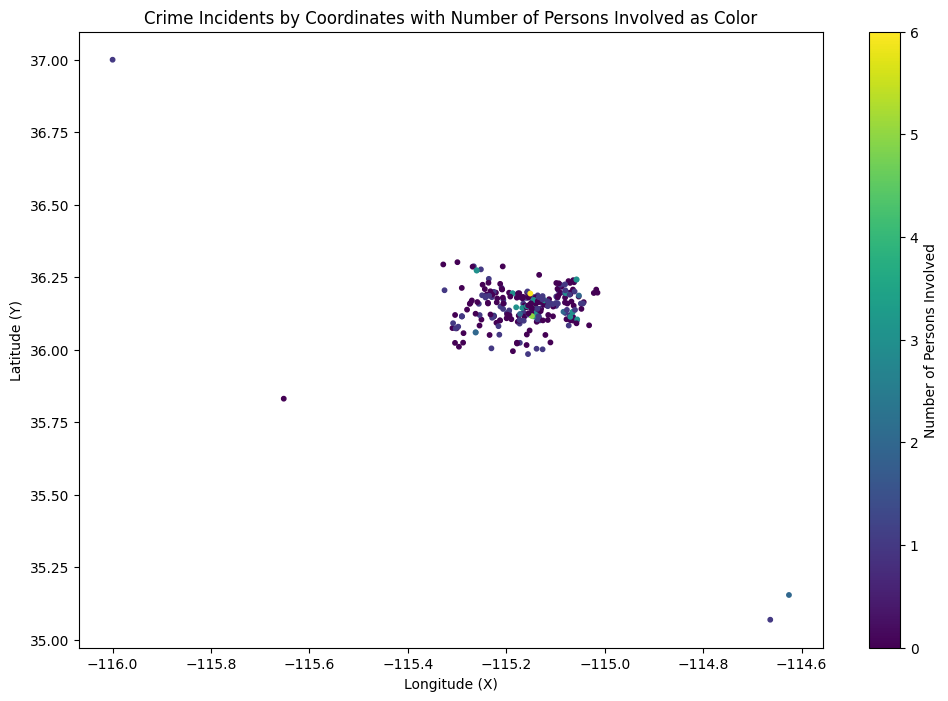

In [245]:
# Create a scatter plot using coordinates and color by the number of persons involved
plt.figure(figsize=(12, 8))

# You can adjust the colormap (cmap) as needed
plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='viridis', s=10)

plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Incidents by Coordinates with Number of Persons Involved as Color')
# plt.ylim(35.5, 36.5)  
# plt.xlim(115.4, 114.8)
plt.colorbar(label='Number of Persons Involved')
plt.show()


### The number of persons involved are less in the crime incidents mostly there are 0 to 1 victims.

In [246]:
# Count the number of crimes reported for each day of the week
crime_counts_by_day = df['DayOfWeek'].value_counts()

# Sort the counts in descending order
sorted_crime_counts = crime_counts_by_day.sort_values(ascending=False)

# Print the sorted counts
print(sorted_crime_counts)


DayOfWeek
4    51
3    44
5    43
0    40
1    37
2    32
6    28
Name: count, dtype: int64


### The number of crimes are more on 4th day of the week, then 3rd, 5th and 0th day respectively and less on the 6th day of the week 